# Project 1.1 - Fuzzy System

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import lib.utils as util
import warnings
from skfuzzy import control as ctrl
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

#### Data Preprocessing

In [112]:
data = pd.read_csv('data/dataset.csv')
data.dropna(inplace=True)
# prepare dates
data['Date'] = data['Date'].astype(str)+' '+data['Time'].astype(str)
data.drop(columns=['Time'], inplace=True)
df_without_outliers = util.detect_and_remove_outliers_std(
    data, k=6, ignore_cols=('Date', 'Persons'))
# removed 4 outliers (which dont make sense)
df_without_outliers.reset_index(inplace=True, drop=True)

format = "%d/%m/%Y %H:%M:%S"
df_without_outliers['Date'] = df_without_outliers['Date'].apply(lambda date: datetime.datetime.strptime(date, format))
df_without_outliers['Hour'] = df_without_outliers['Date'].apply(lambda time: time.hour)

df_without_outliers.drop('Date', axis=1, inplace=True)
data = df_without_outliers.copy()

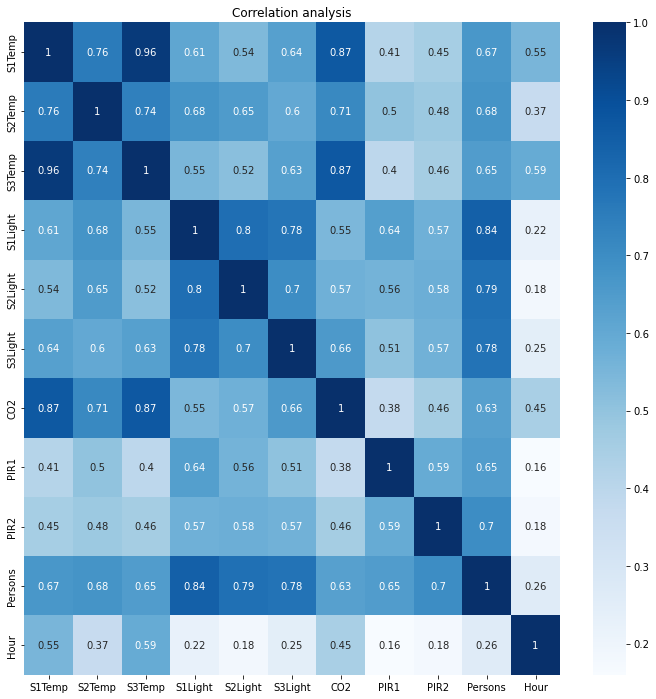

In [113]:
util.plot_corr_matrx(data)


## Baseline

#### FEATURE SELECTION / GENERATION 

In [114]:
# 1 - Merge Temps, Lights, PIRS
target_name = 'Persons'

def prepare_features(data):
    data = data.copy()
    data[target_name] = data[target_name].apply(lambda x: 1 if x > 2 else 0)
    data.drop(columns=['S1Temp', 'S2Temp', 'S3Temp'], inplace=True)
    data['Light'] = data['S1Light'] + data['S2Light'] + data['S3Light'] # total light
    data.drop(columns=['S1Light', 'S2Light', 'S3Light'], inplace=True)
    data.drop(columns=['PIR1', 'PIR2'], inplace=True)
    data['CO2_Diff'] = (data['CO2'] - data['CO2'].shift(10))
    return data

data_prepped = prepare_features(data)
data_prepped.to_csv('data/data_prepped.csv')
y = data_prepped[target_name]
X = data_prepped.drop([target_name], axis=1)
x_valid, x_test, y_valid, y_test = train_test_split(X, y, test_size=0.2)
validation_data = pd.concat([x_valid, y_valid], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)
validation_data.to_csv('data/data_prepped_val.csv')
test_data.to_csv('data/data_prepped_test.csv')
# Split data to use only validation set until the very end

In [115]:
data_prepped = pd.read_csv('data/data_prepped.csv', index_col=0)
validation_data = pd.read_csv('data/data_prepped_val.csv', index_col=0)
y_valid = validation_data[target_name]
x_valid = validation_data.drop([target_name], axis=1)
test_data = pd.read_csv('data/data_prepped_test.csv', index_col=0)
y_test = test_data[target_name]
x_test = test_data.drop([target_name], axis=1)


#### Data Limits

In [116]:
co2_min, co2_max = util.get_extremes(x_valid['CO2'], "CO2")
hour_min, hour_max = util.get_extremes(x_valid['Hour'], "Hour")
light_min, light_max = util.get_extremes(x_valid['Light'], "Light")
co2_diff_min, co2_diff_max = util.get_extremes(x_valid['CO2_Diff'], "CO2_Diff")
person_min, person_max = util.get_extremes(y_valid, "Persons")


CO2 - Min: 345.0 Max: 1270.0
Hour - Min: 0 Max: 23
Light - Min: 0 Max: 1404
CO2_Diff - Min: -90.0 Max: 230.0
Persons - Min: 0 Max: 1


#### Initialize Fuzzy Variables

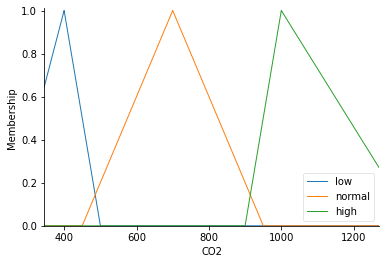

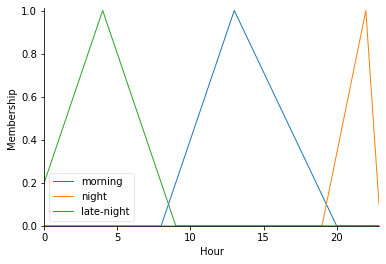

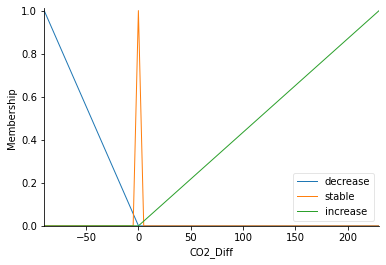

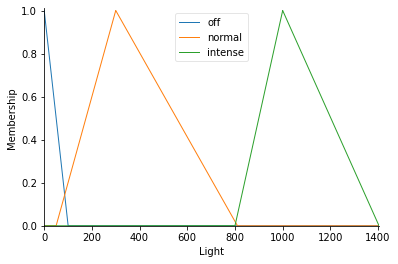

In [117]:
# New Antecedent/Consequent objects hold universe variables and membership
# functions
co2 = ctrl.Antecedent(np.arange(co2_min, co2_max, 0.1), 'CO2')
hour = ctrl.Antecedent(np.arange(hour_min, hour_max, 0.1), 'Hour')
light = ctrl.Antecedent(np.arange(light_min, light_max, 0.1), 'Light')
co2_diff = ctrl.Antecedent(np.arange(co2_diff_min, co2_diff_max, 0.1),
                           'CO2_Diff')
persons = ctrl.Consequent([0, 1], 'Persons')

persons.automf(names=['False', 'True'])

# custom ranges for rules
co2['low'] = fuzz.trimf(co2.universe, [co2_min-100, 400, 500])
co2['normal'] = fuzz.trimf(co2.universe, [450, 700, 950])
co2['high'] = fuzz.trimf(co2.universe, [900, 1000, co2_max+100])
hour['morning'] = fuzz.trimf(hour.universe, [8, 13, 20])
hour['night'] = fuzz.trimf(hour.universe, [19, 22, 23])
hour['late-night'] = fuzz.trimf(hour.universe, [-1, 4, 9])
co2_diff['decrease'] = fuzz.trimf(co2_diff.universe, [co2_diff_min*2, co2_diff_min, 0])
co2_diff['stable'] = fuzz.trimf(co2_diff.universe, [-5, 0, 5])
co2_diff['increase'] = fuzz.trimf(co2_diff.universe, [0, co2_diff_max, co2_diff_max*2])
light['off'] = fuzz.trimf(light.universe, [0, 0, 100])
light['normal'] = fuzz.trimf(light.universe, [50, 300, 810])
light['intense'] = fuzz.trimf(light.universe, [800, 1000, light_max])

co2.view()
hour.view()
co2_diff.view()
light.view()

#### Create Fuzzy Rules


In [121]:
def add_antecedent(orig, new):
    if (orig is None):
        return new
    else:
        return orig | new

def get_antecedent(ant_chain, ant, value):
    if value is not None and value != '':
        if ant_chain is None:
            ant_chain = ant[str(value)]
        else:
            ant_chain = ant_chain & ant[str(value)]
    return ant_chain

def get_antecedents(values):
    ant_chain = None
    ant_chain = get_antecedent(ant_chain, co2, values['CO2'])
    ant_chain = get_antecedent(ant_chain, co2_diff, values['CO2_Diff'])
    ant_chain = get_antecedent(ant_chain, hour, values['Hour'])
    ant_chain = get_antecedent(ant_chain, light, values['Light'])

    return ant_chain

def load_rules():
    rules_df = pd.read_csv("data/rules.csv",
                       delimiter=";",
                       keep_default_na=False,
                       na_values=None)  # for excel formatted csv's
    positive_antecedents = None
    negative_antecedents = None

    for _, values in rules_df.iterrows():
        antecedents = get_antecedents(values)
        if values['Persons']:
            positive_antecedents = add_antecedent(positive_antecedents,
                                                antecedents)
        else:
            negative_antecedents = add_antecedent(negative_antecedents,
                                                antecedents)
    rule0 = ctrl.Rule(antecedent=positive_antecedents,
                    consequent=persons['True'],
                    label="More than 3")
    rule1 = ctrl.Rule(antecedent=negative_antecedents,
                    consequent=persons['False'],
                    label="Less than 3")
    return [rule0, rule1], rules_df

# only two rules has better performance vs many rules

#### Create Prediction System

In [122]:
rules, rules_df = load_rules()
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system, cache=False)

#### Tuning the rules

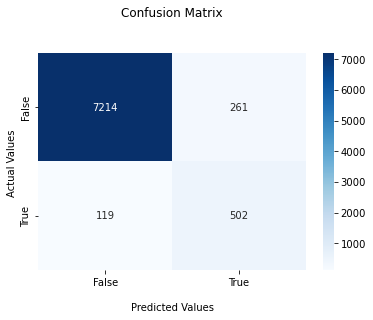

Accuracy: 0.9530632411067194
Recall: 0.8083735909822867
Precision: 0.6579292267365662
F1-Score: 0.7254335260115607


In [120]:
# IF persons < 0.5 then its true, else false

def run_predictions(x: pd.DataFrame, y: pd.DataFrame, sim):
    y_pred = []
    for _, values in x.iterrows():
        for col, val in zip(x.columns, values):
            sim.input[col] = val
        sim.compute()
        val_pred = sim.output['Persons']
        pred = True if val_pred is not None and val_pred > 0.5 else False  # if its higher than 0.5 then there are more than 2 persons
        y_pred.append(pred)
    # print(y_pred)
    return util.get_results(y, y_pred)

acc, rec, prec, f1 = run_predictions(x_valid, y_valid, sim)
print(f'Accuracy: {acc}')
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'F1-Score: {f1}')


In [110]:
util.save_system("best_system", system)
# saved the best system, when tuning the rules

#### Final Results

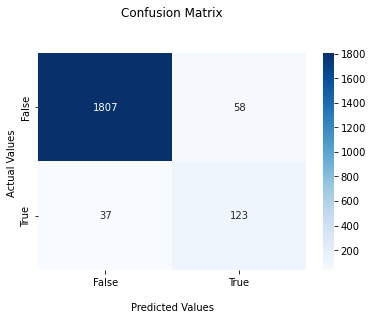

Accuracy: 0.9530864197530864
Recall: 0.76875
Precision: 0.6795580110497238
F1-Score: 0.7214076246334312


In [108]:
## Test with the train set and evaluate the results
acc, rec, prec, f1 = run_predictions(x_test, y_test, sim)
print(f'Accuracy: {acc}')
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'F1-Score: {f1}')